# Damage Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from xview2comp.nb_02c import *

### Data

In [3]:
SOURCE = Path('data/train')
SOURCE.ls()

[PosixPath('data/train/train.tar.gz'),
 PosixPath('data/train/images'),
 PosixPath('data/train/damagemasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks')]

In [57]:
datadf = pd.read_csv('class_labels_tiny.csv')

In [58]:
datadf.head()

,damage,uid
0,no-damage,7ae792ae-64b5-41ec-be7b-14873c450650
1,no-damage,4ca98eb5-10bd-4d75-b3b3-3b9012291c1f
2,no-damage,22e5eb6a-f924-4b27-9cb0-90b112bcfd66
3,no-damage,e2ef0265-66e4-4104-a1a9-3fa985275a1d
4,no-damage,e4e531da-2183-440a-9501-66873422625e


In [59]:
datadf.damage.value_counts()

no-damage        670
minor-damage      80
major-damage      78
destroyed         56
un-classified     14
Name: damage, dtype: int64

In [70]:
base_level = 'no-damage/un-classified'

In [73]:
datadf.damage.replace('no-damage', base_level, inplace=True)

In [75]:
datadf.damage.replace('un-classified', base_level, inplace=True)

In [77]:
datadf.damage.value_counts()

no-damage/un-classified    684
minor-damage                80
major-damage                78
destroyed                   56
Name: damage, dtype: int64

In [60]:
fnames = [SOURCE/'classification_images'/f'{o}.png' for o in datadf.uid]
fnames[:3]

[PosixPath('data/train/classification_images/7ae792ae-64b5-41ec-be7b-14873c450650.png'),
 PosixPath('data/train/classification_images/4ca98eb5-10bd-4d75-b3b3-3b9012291c1f.png'),
 PosixPath('data/train/classification_images/22e5eb6a-f924-4b27-9cb0-90b112bcfd66.png')]

In [61]:
val_idx = get_random_val_idx(len(fnames))    

In [63]:
il = ImageList(fnames) 

In [64]:
sd = il.split_by_idx(val_idx)

In [65]:
damgcats = DamageCategorize()

In [78]:
def get_label(fname):
    return datadf[datadf.uid == fname.stem].damage.values[0]

In [86]:
cats = list(datadf.damage.value_counts().index)
cats

['no-damage/un-classified', 'minor-damage', 'major-damage', 'destroyed']

In [87]:
src = (ImageList(fnames)
       .split_by_idx(val_idx)
       .label_from_func(get_label, classes=cats))

In [111]:
bs = 8
sz = 64
tfms = get_transforms(flip_vert=True, max_rotate=.2, max_warp=0., max_zoom=1.1, max_lighting=.4)
data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [112]:
data

ImageDataBunch;

Train: LabelList (809 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
no-damage/un-classified,no-damage/un-classified,no-damage/un-classified,no-damage/un-classified,no-damage/un-classified
Path: data;

Valid: LabelList (89 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
no-damage/un-classified,no-damage/un-classified,destroyed,no-damage/un-classified,no-damage/un-classified
Path: data;

Test: None

no-damage/un-classified
data/train/classification_images/d0357850-07fa-440c-8290-9fa432cf7455.png


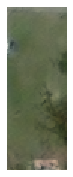

In [113]:
idx = 11

data.valid_ds.x[idx].show()
print(data.valid_ds.y[idx], data.valid_ds.items[idx], sep='\n')

In [114]:
data.train_ds.classes

['no-damage/un-classified', 'minor-damage', 'major-damage', 'destroyed']

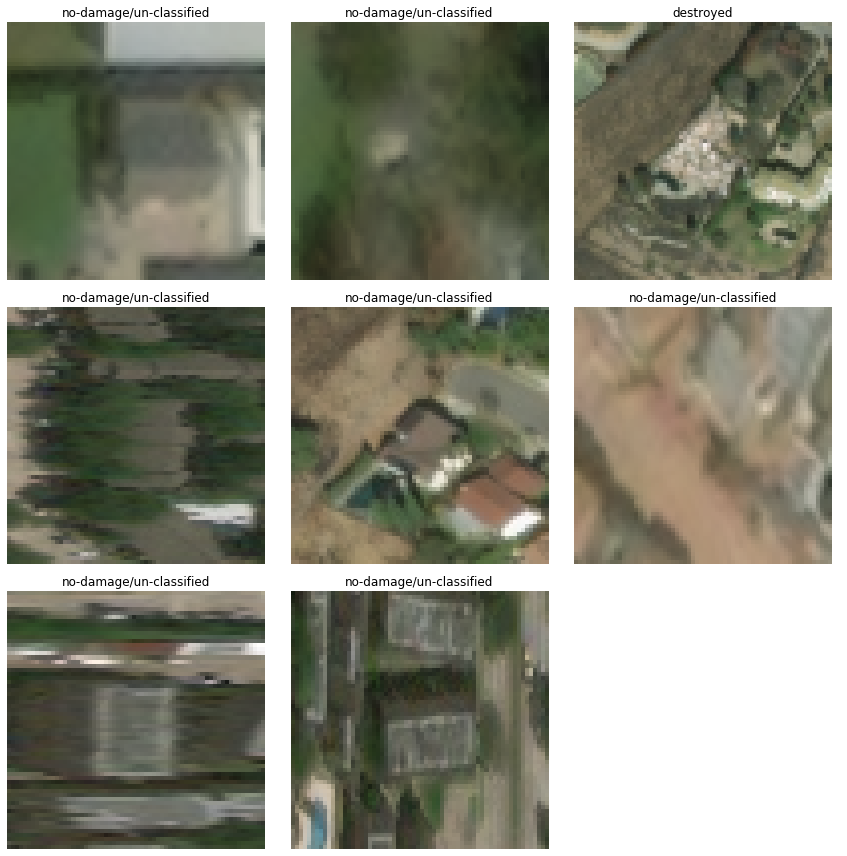

In [115]:
data.show_batch(rows=4, figsize=(12, 12), ds_type=DatasetType.Valid)

In [116]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training

In [118]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [119]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


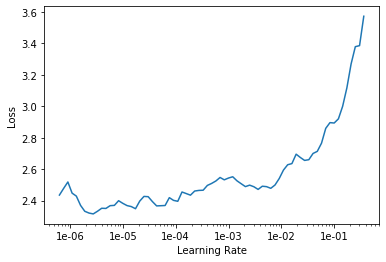

In [122]:
learn.recorder.plot()

In [123]:
lr = 1e-5

In [124]:
learn.fit_one_cycle(4, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.476074,1.909445,0.741573,01:14
1,2.298161,1.642453,0.651685,01:07
2,2.404240,1.569391,0.640449,01:07
3,2.249557,1.545593,0.606742,01:08


In [125]:
learn.save('damg_classifier_sz64')
learn.load('damg_classifier_sz64');

# -fin